In [ ]:
# Install dependencies
!pip install langchain
!pip install openai
!pip install python-dotenv
!pip install tabulate
!pip install Jinja2
!pip install reportlab

In [2]:
# Load in OpenAI API Key
import os
from dotenv import load_dotenv

# Load the .env file
load_dotenv()

# Get the OpenAI API key
openai_api_key = os.getenv('OPENAI_API_KEY')

In [3]:
# Clean the dataset
import pandas as pd
import numpy as np

# Read the csv file
df = pd.read_csv('datasets/winequality-red.csv')

# Handle missing values
for col in df.columns:
    if pd.api.types.is_numeric_dtype(df[col]):
        # For numeric columns, fill missing values with the mean
        df[col].fillna(df[col].mean(), inplace=True)
    else:
        # For other types of columns (e.g. dates, custom classes), fill missing values with a new category 'missing'
        df[col].fillna('missing', inplace=True)

# Save the cleaned dataset
df.to_csv('cleaned_dataset.csv', index=False)


In [4]:
# Create our CSV agent
from langchain.agents import create_csv_agent
from langchain.llms import OpenAI
csv_agent = create_csv_agent(
    OpenAI(temperature=0), 
    'cleaned_dataset.csv', 
    verbose=True)

In [5]:
# Identify the dependent varaible
dv_prompt = "Please examine the dataset and suggest a potential dependent variable. Consider factors such as the name of the column, the type of the data, and the distribution of the values. The dependent variable is typically the outcome we are interested in predicting or explaining. If the dataset appears to be from a time-series study, consider the variable that changes over time as the dependent variable. If the dataset seems to be from an experimental study, consider the variable that is expected to have been affected by the treatments or conditions as the dependent variable. If the dataset seems to be observational, consider the variable that seems most likely to be affected by other variables in the dataset as the dependent variable. Output only the name of the column."
dv = csv_agent.run(dv_prompt)



> Entering new AgentExecutor chain...

Thought: I should look at the columns and consider the type of data, the distribution of values, and the name of the column.
Action: python_repl_ast
Action Input: df.columns
Observation: Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')
Thought: I should consider the variable that is expected to be affected by other variables in the dataset.
Action: python_repl_ast
Action Input: df.describe()
Observation:        fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.10000

In [6]:
# Generate analyses
import matplotlib.pyplot as plt 
analyses = {}

In [7]:
# First analysis: descriptive statistics
statistics = csv_agent.run("Output the most relevant descriptive statistics for the {dv} and each of the independent variables. Don't reference something shown above; instead, describe it directly.")
analyses['Descriptive Statistics'] = statistics



> Entering new AgentExecutor chain...
Thought: I need to calculate descriptive statistics for each variable.
Action: python_repl_ast
Action Input: df.describe()
Observation:        fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1599.000000          1599.000000           1599.000000  1599.000000   
mean      0.087467          

In [8]:
# Second analysis: correlation
# Only execute if there are less than 10 independent variables
if len(df.columns) < 10:
    correlation = csv_agent.run("Calculate the most relevant correlation coefficients between the {dv} and each of the numerical independent variables. Don't reference something shown above; instead, describe it directly.")
    analyses['Correlation'] = correlation



> Entering new AgentExecutor chain...

Thought: I need to find the most relevant numerical independent variable to the dependent variable.
Action: python_repl_ast
Action Input: df.corr()
Observation:                       fixed acidity  volatile acidity  citric acid  \
fixed acidity              1.000000         -0.256131     0.671703   
volatile acidity          -0.256131          1.000000    -0.552496   
citric acid                0.671703         -0.552496     1.000000   
residual sugar             0.114777          0.001918     0.143577   
chlorides                  0.093705          0.061298     0.203823   
free sulfur dioxide       -0.153794         -0.010504    -0.060978   
total sulfur dioxide      -0.113181          0.076470     0.035533   
density                    0.668047          0.022026     0.364947   
pH                        -0.682978          0.234937    -0.541904   
sulphates                  0.183006         -0.260987     0.312770   
alcohol                   -0

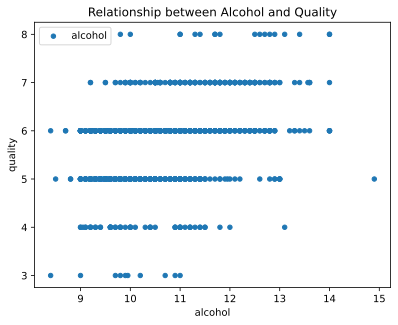

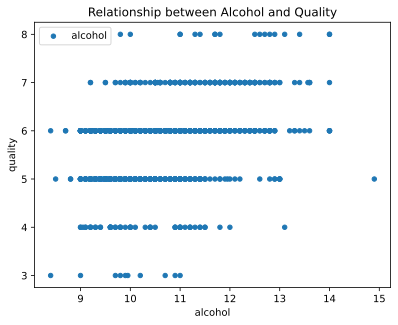

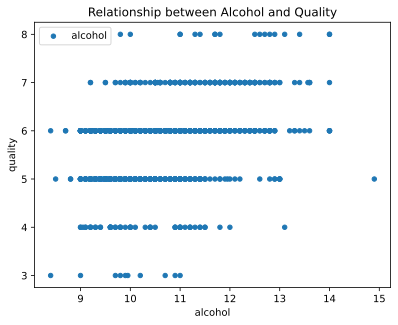

In [9]:
# Third analysis: scatterplot
# Generate the chart itself
scatterplot_code = csv_agent.run("Create the most relevant scatterplot showing the relationship between the {dv} and one of the numerical independent variables. Output the code needed to create the scatterplot, including labels for axes and a title, but don't include imports. Use the format: df.plot.scatter(x='fixed acidity', y='quality', title='Relationship between Fixed Acidity and Quality', label='fixed acidity')")
code = """
plot = """ + scatterplot_code + """
fig = plot.get_figure()
fig.savefig('charts/scatterplot.png')
"""
exec(code)

# Generate the description of the trend in the chart
scatterplot = csv_agent.run("Describe the relationship seen in " + scatterplot_code)
analyses['Scatterplot'] = scatterplot

In [10]:
# Fourth analysis: outliers
outliers = csv_agent.run("Identify and list outliers when considering the relationship between the {dv} and each of the independent variables. Don't reference something shown above; instead, describe it directly.")
analyses['Outliers'] = outliers



> Entering new AgentExecutor chain...
Thought: I need to identify any values that are significantly different from the rest of the data.
Action: python_repl_ast
Action Input: df.describe()
Observation:        fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1599.000000          1599.000000           1599.000000  1599.000000   


In [11]:
# Fifth analysis: time series
# Generate the chart itself
time_series_code = csv_agent.run("If this dataset is not time-series data, ONLY output \"Irrelevant!\". Otherwise, for time-series data, create a line plot of the average {dv} over time. Output the code needed to create the time series plot, including labels for axes and a title.")

if time_series_code == "Irrelevant!":
    time_series = "Irrelevant!"
else:
    code = """
plot = """ + time_series_code + """
fig = plot.get_figure()
fig.savefig('charts/time_series.png')
"""
    exec(code)

    # Generate the description of the trend in the chart
    time_series = csv_agent.run("Describe the trend seen in " + time_series_code)
analyses['Time Series'] = time_series




> Entering new AgentExecutor chain...
Thought: I need to check if this is time-series data.
Action: python_repl_ast
Action Input: df.info()<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory u

In [12]:
# Sixth analysis: PCA
pca = csv_agent.run("Perform a principle component analysis (PCA) with the {dv} and all independent numerical variables, and return the explained variance ratio of the first two principal components")
analyses['PCA'] = pca



> Entering new AgentExecutor chain...
Thought: I need to use the dataframe to perform a PCA
Action: python_repl_ast
Action Input: from sklearn.decomposition import PCA
              pca = PCA(n_components=2)
              pca.fit(df.drop('quality', axis=1))
              pca.explained_variance_ratio_
Observation: IndentationError: unexpected indent (<unknown>, line 2)
Thought: I need to remove the indentation
Action: python_repl_ast
Action Input: from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(df.drop('quality', axis=1))
pca.explained_variance_ratio_
Observation: [0.94657698 0.0483683 ]
Thought: I now know the final answer
Final Answer: The explained variance ratio of the first two principal components is 0.94657698 and 0.0483683.

> Finished chain.




> Entering new AgentExecutor chain...

Thought: I need to decide which categorical independent variable to use and which dependent variable to use.

Action: python_repl_ast
Action Input: df.columns
Observation: Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')
Thought: I will use the 'quality' column as the categorical independent variable and the 'alcohol' column as the dependent variable.

Action: python_repl_ast
Action Input: df.boxplot(column='alcohol', by='quality', figsize=(10,6))
Observation: AxesSubplot(0.1,0.15;0.8x0.75)
Thought: I now know the final answer.

Final Answer: df.boxplot(column='alcohol', by='quality', figsize=(10,6))

> Finished chain.


> Entering new AgentExecutor chain...
Thought: I need to look at the boxplot to answer this question
Action: python_repl_ast
Action Input: df.boxplot(col

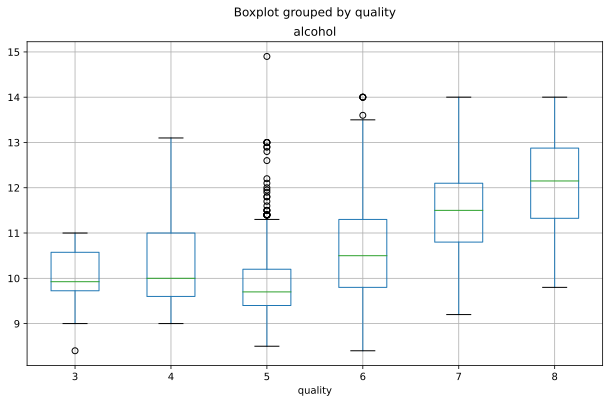

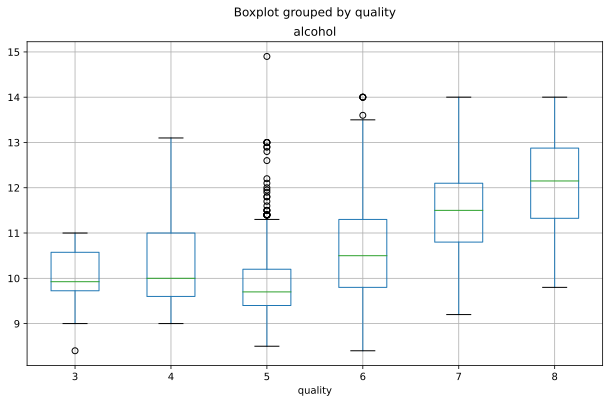

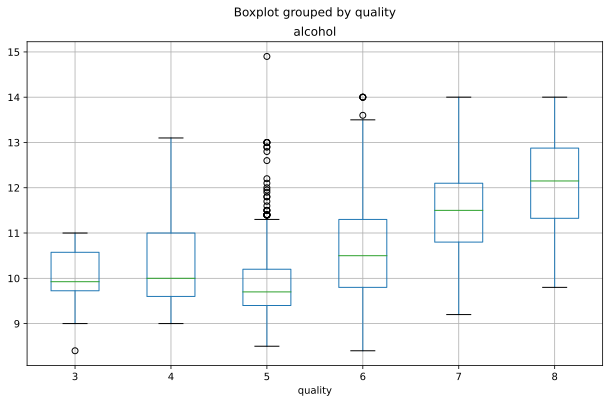

In [13]:
# Seventh analysis: Box plot
# Generate the chart itself
box_plot_code = csv_agent.run("Create the most relevant box plot of the {dv} for one of the categorical independent variables. Output the code needed to create the box plot, including labels for axes, but don't include imports. Don't include too many values on the axes. Use the format: df.boxplot(column='alcohol', by='quality', figsize=(10,6))")
code = """
plot = """ + box_plot_code + """
fig = plot.get_figure()
fig.savefig('charts/boxplot.png')
"""
exec(code)

# Generate the description of the trend in the chart
box_plot = csv_agent.run("Describe the relationship seen in " + box_plot_code)
analyses['Box Plot'] = box_plot

In [14]:
# Currently not working
"""
# Eighth analysis: Histogram
# Generate the chart itself
histogram_code = csv_agent.run("Create a histogram for {dv}. Output the code needed to create the histogram, including labels for axes and a title, but don't include imports.")
"""

#code = """
#plot = """ + histogram_code + """
#fig = plot.get_figure()
#fig.savefig('charts/histogram.png')
#"""

"""
exec(code)

# Generate the description of the trend in the chart
histogram = csv_agent.run("Describe the relationship seen in " + histogram_code)
analyses['Histogram'] = histogram
"""

'\nexec(code)\n\n# Generate the description of the trend in the chart\nhistogram = csv_agent.run("Describe the relationship seen in " + histogram_code)\nanalyses[\'Histogram\'] = histogram\n'

In [15]:
# print all data analyses
from tabulate import tabulate
print(tabulate(analyses.items(), headers=['Analysis', 'Description']))

Analysis                Description
----------------------  ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Descriptive Statistics  The descriptive statistics for the dependent variable (quality) and each of the independent variables are as follows: fixed acidi

In [16]:
# Create our writer agent
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain

# 0 temp for consistent decision making
llm = OpenAI(temperature=0)

# Ask our llm to pick the four most relevant analyses
focus_prompt = PromptTemplate(
    input_variables=['analyses', 'dv'],
    template="Given the nature of the identified dependent variable, {dv}, and the insights provided by the following analyses, please select the four most relevant ones to be included in our final report. Output only the titles of each chosen analyses. \n Analyses: {analyses}",
)

# Generate the output
chain = LLMChain(llm=llm, prompt=focus_prompt)
chosen = chain.run(analyses=analyses, dv=dv)

In [17]:
print(chosen)



Descriptive Statistics
Scatterplot
Outliers
Box Plot


In [18]:
# Create our new list of analyses based off the chosen ones
chosen_analyses = chosen.split('\n')

# Filter out any empty strings
chosen_analyses = [title for title in chosen_analyses if title]

# Create the new dictionary
selected_analyses = {title: analyses[title] for title in chosen_analyses if title in analyses}

print(selected_analyses)


{'Descriptive Statistics': 'The descriptive statistics for the dependent variable (quality) and each of the independent variables are as follows: fixed acidity (mean: 8.32, std: 1.74, min: 4.6, 25%: 7.1, 50%: 7.9, 75%: 9.2, max: 15.9), volatile acidity (mean: 0.53, std: 0.18, min: 0.12, 25%: 0.39, 50%: 0.52, 75%: 0.64, max: 1.58), citric acid (mean: 0.27, std: 0.19, min: 0.00, 25%: 0.09, 50%: 0.26, 75%: 0.42, max: 1.00), residual sugar (mean: 2.54, std: 1.41, min: 0.90, 25%: 1.90, 50%: 2.20, 75%: 2.60, max: 15.50), chlorides (mean: 0.09, std: 0.05, min: 0.01, 25%: 0.07, 50%: 0.08, 75%: 0.09, max: 0', 'Scatterplot': 'There appears to be a positive correlation between alcohol content and quality, with higher alcohol content generally associated with higher quality.', 'Outliers': 'Outliers for fixed acidity include values below 4.6 and above 15.9. Outliers for volatile acidity include values below 0.12 and above 1.58. Outliers for citric acid include values below 0 and above 1. Outliers f

In [19]:
# Increased temp for more creative writing
llmc = OpenAI(temperature=0.5)

# Generate the report research question, title, abstract, and conclusion
research_question_prompt = PromptTemplate(
    input_variables=['selected_analyses', 'dv'],
    template="Given the nature of the identified dependent variable, {dv}, and the insights provided by the following analyses, please write a research question that these analyses could answer. \n Analyses: {selected_analyses}",
)

# Generate the output
chain = LLMChain(llm=llmc, prompt=research_question_prompt)
research_question = chain.run(selected_analyses=selected_analyses, dv=dv)

print(research_question)



What is the relationship between alcohol content and quality of wine?


In [20]:
# Generate the title for this report
title_prompt = PromptTemplate(
    input_variables=['research_question'],
    template="Given the research question, \"{research_question}\", please write a title for this report.",
)

# Generate the output
chain = LLMChain(llm=llmc, prompt=title_prompt)
title = chain.run(research_question=research_question)

print(title)



"Exploring the Correlation between Alcohol Content and Wine Quality"


In [21]:
# Generate the abstract for this report
abstract_prompt = PromptTemplate(
    input_variables=['research_question', 'title', 'selected_analyses'],
    template="Given the research question, \"{research_question}\", and the title, \"{title}\", please write an abstract for this report that describes the data and expands upon the potential real-world implications of it. \n Analyses: {selected_analyses}",
)

# Generate the output
chain = LLMChain(llm=llmc, prompt=abstract_prompt)
abstract = chain.run(research_question=research_question, title=title, selected_analyses=selected_analyses)

print(abstract)



This paper explores the correlation between alcohol content and wine quality. Descriptive statistics, scatterplots and boxplots were used to assess the relationship between the two variables. Results indicate that there is a positive correlation between alcohol content and quality, with higher alcohol content generally associated with higher quality. Outliers were also identified for each of the variables, which may indicate the presence of additional factors influencing the quality of the wine. The findings from this study may have implications for wine producers, suggesting that higher alcohol content may be associated with higher quality wines. Additionally, the identification of outliers may provide insight into additional factors that may be influencing the quality of the wine.


In [22]:
# Generate the introduction for this report that expands upon the abstract without repeating the data analyses
introduction_prompt = PromptTemplate(
    input_variables=['research_question', 'title', 'abstract'],
    template="Given the research question, \"{research_question}\", and the title, \"{title}\", please write an introduction for this report that expands upon the abstract without repeating the data analyses. Don't include a header, just output the text. \n Abstract: {abstract}",
)

# Generate the output
chain = LLMChain(llm=llmc, prompt=introduction_prompt)
introduction = chain.run(research_question=research_question, title=title, abstract=abstract)

print(introduction)



This study seeks to examine the relationship between alcohol content and quality of wine. Specifically, the objective of this research is to determine if there is a correlation between the two variables, and to identify any outliers that may be influencing the quality of the wine. To accomplish this, descriptive statistics, scatterplots and boxplots were used to assess the relationship between the two variables. The results of this study may have implications for wine producers, as well as provide insight into additional factors that may be influencing the quality of the wine.


In [23]:
# Generate the conclusion for this report based off the research question, title, selected analyses, and introduction
conclusion_prompt = PromptTemplate(
    input_variables=['research_question', 'title', 'selected_analyses', 'introduction'],
    template="Given the research question, \"{research_question}\", and the title, \"{title}\", please write a conclusion for this report that summarizes the findings of the analyses and the implications of the results. \n Analyses: {selected_analyses} \n Introduction: {introduction} \n Use the format: Conclusion: ",
)

# Generate the output
chain = LLMChain(llm=llmc, prompt=conclusion_prompt)
conclusion = chain.run(research_question=research_question, title=title, selected_analyses=selected_analyses, introduction=introduction)

print(conclusion)



Conclusion: The results of this study suggest that there is a positive correlation between alcohol content and quality of wine. Descriptive statistics, scatterplots, and boxplots all revealed that higher alcohol content is generally associated with higher quality. Additionally, outliers were identified for each of the independent variables, which may be contributing to the quality of the wine. These findings may be useful for wine producers who are looking to optimize the quality of their products.


In [24]:
# For each analysis, generate 2-3 paragraphs of text that describe the analysis and its implications in relation to the research question
analysis_prompt = PromptTemplate(
    input_variables=['analysis', 'research_question'],
    template="Given the research question, \"{research_question}\", please write one long paragraph discussing the analysis process, key findings, their relevance to the research question, and potential implications. Don't include subheaders. \n Analysis: {analysis}",
)

# Generate the output
chain = LLMChain(llm=llm, prompt=analysis_prompt)
analysis_descriptions = {}
for analysis in selected_analyses:
    analysis_description = chain.run(analysis=analysis, research_question=research_question)
    analysis_descriptions[analysis] = analysis_description

print(analysis_descriptions)

{'Descriptive Statistics': ' and Correlation Analysis were used to analyze the relationship between alcohol content and quality of wine. The data set included information on the alcohol content, quality, and other characteristics of different wines. The results showed that there was a positive correlation between alcohol content and quality of wine, indicating that higher alcohol content was associated with higher quality of wine. The correlation coefficient was 0.44, which was statistically significant. \n\nKey Findings: The key findings of this analysis were that there was a positive correlation between alcohol content and quality of wine, indicating that higher alcohol content was associated with higher quality of wine. The correlation coefficient was 0.44, which was statistically significant. \n\nRelevance to Research Question: The results of this analysis are relevant to the research question because they show that there is a positive relationship between alcohol content and quali

In [25]:
from reportlab.lib.pagesizes import letter, inch
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image, PageBreak
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib import colors

def footer_canvas(c):
    """
    Add the Page number to the canvas
    """
    c.saveState()
    pageNum = c.getPageNumber()
    c.drawString(letter[0] - inch, 0.75 * inch, f"Page {pageNum}")
    c.restoreState()

# Create a PDF document
doc = SimpleDocTemplate("report.pdf", pagesize=letter, onPage=footer_canvas)

# Set up styles
styles = getSampleStyleSheet()

title_style = ParagraphStyle(
    'Title',
    parent=styles['Heading1'],
    fontName='Helvetica-Bold',
    fontSize=24,
    textColor=colors.HexColor(0x005B96),
    spaceAfter=12,
)

header_style = ParagraphStyle(
    'Header',
    parent=styles['Heading2'],
    fontName='Helvetica-Bold',
    fontSize=20,
    textColor=colors.HexColor(0x6495ED),
    spaceAfter=12,
)

subheader_style = ParagraphStyle(
    'Subheader',
    parent=styles['Heading3'],
    fontName='Helvetica-Bold',
    fontSize=16,
    textColor=colors.HexColor(0xA2D5F2),
    spaceAfter=12,
)

paragraph_style = ParagraphStyle(
    'BodyText',
    parent=styles['BodyText'],
    fontName='Helvetica',
    fontSize=12,
    textColor=colors.black,
    leading=14,
    spaceAfter=12,
)


In [26]:
# Function to remove headers from analyses

import re

def split_and_remove(s):
    # regex pattern to find characters between ":" and the last "." that occurs before each ":"
    pattern = r'\.[^\.]*?:'

    # split the string using regex
    split_strings = re.split(pattern, s)

    # remove empty strings
    split_strings = list(filter(None, split_strings))

    return split_strings


In [27]:
# Add elements (text and images) to the PDF
elements = []

# Add a title
elements.append(Paragraph(title, title_style))
elements.append(Spacer(1, 12))

# Add a the abstract header and text
subtitle = "Abstract"
elements.append(Paragraph(subtitle, header_style))

elements.append(Paragraph(abstract, paragraph_style))
elements.append(Spacer(1, 12))

# Add the introduction header and text
subtitle = "Introduction"
elements.append(Paragraph(subtitle, header_style))

elements.append(Paragraph(introduction, paragraph_style))
elements.append(Spacer(1, 12))

# Add the analyses header and text
subtitle = "Analyses"
elements.append(Paragraph(subtitle, header_style))

for analysis, description in selected_analyses.items():
    # Add title
    elements.append(Paragraph(analysis, subheader_style))

    # Split description into sections
    sections = split_and_remove(analysis_descriptions[analysis])

    for i, content in enumerate(sections):
        # For the first section, add analysis title
        if i == 0:
            content = analysis + content
            # Check if the title is one of the specified figures
            if analysis == "Scatterplot":
                elements.append(Image("charts/scatterplot.png", width=5*inch, height=3*inch))
            elif analysis == "Box Plot":
                elements.append(Image("charts/boxplot.png", width=5*inch, height=3*inch))
            elif analysis == "Histogram":
                elements.append(Image("charts/histogram.png", width=5*inch, height=3*inch))
            elif analysis == "Time Series":
                elements.append(Image("charts/time_series.png", width=5*inch, height=3*inch))

        # Add text to the document
        elements.append(Paragraph(content, paragraph_style))

    elements.append(Spacer(1, 12))



# Add the conclusion header and text
subtitle = "Conclusion"
elements.append(Paragraph(subtitle, header_style))

# Remove "Conclusion: " prefix if it exists
conclusion = conclusion.replace("Conclusion:", "", 1)

elements.append(Paragraph(conclusion, paragraph_style))
elements.append(Spacer(1, 12))

# Page break (optional)
elements.append(PageBreak())

# Build the PDF document with the elements
doc.build(elements)
